<a href="https://colab.research.google.com/github/AncaIoanaMuscalagiu/ProteinFoldingNotebooks/blob/main/Mine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
from collections import OrderedDict

import gym
from gym import (spaces, logger)
import numpy as np


import numpy as np

ACTION_TO_MEANING_2D = {1: (-1, 0), 2: (1, 0), 3: (0, -1), 4: (0, 1)}
ACTION_TO_MEANING_3D = {1: (-1, 0, 0), 2: (1, 0, 0), 3: (0, -1, 0), 4: (0, 1, 0), 5: (0, 0, -1), 6: (0, 0, 1)}
ACTION_TO_DIRECTION = {
    (-1, 0): {'L': (0, -1), 'R': (0, 1), 'F': (-1, 0)},
    (1, 0): {'L': (0, 1), 'R': (0, -1), 'F': (1, 0)},
    (0, -1): {'L': (1, 0), 'R': (-1, 0), 'F': (0, -1)},
    (0, 1): {'L': (0, -1), 'R': (1, 0), 'F': (0, 1)},
}
ACTION_TO_LRF = {
    1: 'L',
    2: 'R',
    3: 'F'
}
LRF_TO_ACTION = {
    'L': 1,
    'R': 2,
    'F': 3
}
ACTION_TO_MEANING_TRIANGULAR = {
    1: (-1, 0), 2: (1, 0), 3: (0, -1), 4: (0, 1), 5: (1, 1), 6: (-1, -1)
}


def move_to_new_state_lrf(previous_move_direction, state, action):
    if action not in {1, 2, 3}:
        return

    action_lrf = ACTION_TO_LRF[action]
    current_move_direction = ACTION_TO_DIRECTION[previous_move_direction][action_lrf]
    x1, y1 = state

    new_state = (x1 + current_move_direction[0], y1 + current_move_direction[1])

    return current_move_direction, new_state


def move_to_new_state_3d(p1, p2, move_direction):
    if move_direction not in {1, 2, 3, 4, 5, 6}:
        return
    x1, y1, z1 = p1

    new_state = (x1 + (ACTION_TO_MEANING_3D[move_direction])[0], y1 + (ACTION_TO_MEANING_3D[move_direction])[1],
                 z1 + (ACTION_TO_MEANING_3D[move_direction])[2])
    if p2 == new_state:
        return
    return new_state


def move_to_new_state_2d(p1, p2, move_direction):
    if move_direction not in {1, 2, 3, 4}:
        return

    x1, y1 = p1

    new_state = (x1 + (ACTION_TO_MEANING_2D[move_direction])[0], y1 + (ACTION_TO_MEANING_2D[move_direction])[1])
    if p2 == new_state:
        return
    return new_state


def move_to_new_state_triangular(p1, p2, move_direction):
    if move_direction not in {1, 2, 3, 4, 5, 6}:
        return

    x1, y1 = p1
    new_state = (
        x1 + (ACTION_TO_MEANING_TRIANGULAR[move_direction])[0], y1 + (ACTION_TO_MEANING_TRIANGULAR[move_direction])[1])
    if p2 == new_state:
        return
    return new_state

import gym
from gym import (spaces, utils, logger)
import numpy as np

class ProteinFoldingBaseEnv(gym.Env):
    def __init__(self,
                 seq,
                 ):
        self.seq = seq.upper()
        self.is_trapped = False
        self.done = False
        if len(self.seq) <= 2:
            return

    def observe(self):
        action_chain = self.actions
        native_obs = np.zeros(shape=(len(self.seq) - 2,), dtype=int)
        for i, item in enumerate(action_chain):
            native_obs[i] = item
        return native_obs

    def _compute_reward(self):
        curr_reward = self._compute_free_energy(self.state)
        if self.is_trapped:
            return -0.01
        elif self.done:
            return curr_reward
        else:
            return 0

    def _compute_free_energy(self, chain):

        path = list(chain.items())
        total_energy = 0
        for index in range(0, len(path)):
            for jndex in range(index, len(path)):
                if abs(index - jndex) >= 2:
                    current_amino_acid_i = path[index][1]
                    current_amino_acid_j = path[jndex][1]
                    current_place_i = path[index][0]
                    current_place_j = path[jndex][0]
                    x_i = current_place_i[0]
                    y_i = current_place_i[1]
                    x_j = current_place_j[0]
                    y_j = current_place_j[1]
                    if current_amino_acid_i == 'H' and current_amino_acid_j == 'H' and (
                            abs(x_i - x_j) + abs(y_i - y_j) == 1):
                        total_energy += 1
        return total_energy

    def get_observation_info(self, next_state):
        is_trapped = False
        if len(self.state) < len(self.seq):
            if set(self._get_adjacent_coords(next_state).values()).issubset(self.state.keys()):
                is_trapped = True
        obs = self.observe()
        self.is_trapped = is_trapped
        self.done = len(self.state) == len(self.seq) or is_trapped
        reward = self._compute_reward()
        info = {
            'chain_length': len(self.state),
            'seq_length': len(self.seq),
            'actions': [str(i) for i in self.actions],
            'is_trapped': is_trapped,
            'state_chain': self.state,
        }
        return obs, reward, self.done, False, info

    def seed(self, seed=None):
        """
        seed the gym env
        NOTE: this umbrella seed() will seed the end globally
        it will seed:
            action_space
            np random (for uniform to_exploit)
        """
        self.np_random, seed = utils.seeding.np_random(seed)

        # NOTE: spaces sample use separate random number generator
        # that lives in gym.spaces.prng. If you want action / observation
        # space to sample deterministically you will need to seed separately
        self.action_space.seed(seed)
        # NOTE: agent also uses randomness, need to seed that separately
        np.random.seed(seed)

        return [seed]

In [68]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
import numpy as np
import torch
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, MaxNLocator)

from IPython import display
from sklearn.metrics import euclidean_distances


def plot_print_rewards_stats(rewards_all_episodes,
                             show_every,
                             args,
                             mode="show",
                             save_path=""):
    # unpack the args
    seq = "HHPPHH"
    seed = 42
    num_episodes = 10000

    # Calculate and print the average reward per show_every episodes
    rewards_per_N_episodes = np.split(
        np.array(rewards_all_episodes),
        num_episodes
    )
    count = show_every

    # for plotting
    aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}

    print("\n********Stats per {} episodes********\n".format(show_every))
    for r in rewards_per_N_episodes:
        # print(count, "avg: ", str(sum(r/show_every)))
        # print(count, "min: ", str(min(r)))
        # print(count, "max: ", str(max(r)))

        aggr_ep_rewards['ep'].append(count)
        aggr_ep_rewards['avg'].append(sum(r / show_every))
        aggr_ep_rewards['min'].append(min(r))
        aggr_ep_rewards['max'].append(max(r))

        count += show_every

    # Width, height in inches.
    # default: [6.4, 4.8]
    fig_width = 6.4
    fig_height = 4.8
    # adjust the height of the histogram
    if np.array(rewards_all_episodes).max() - np.array(rewards_all_episodes).min() > 10:
        fig_width = 6.5
        fig_height = 6.5
    fig, subplot = plt.subplots(figsize=(fig_width, fig_height))
    # Be sure to only pick integer tick locations
    subplot.yaxis.set_major_locator(MaxNLocator(integer=True))
    # subplot.yaxis.set_major_locator(MultipleLocator(1))
    subplot.yaxis.set_minor_locator(MultipleLocator(1))

    subplot.set_xlabel('Episode Index')
    subplot.set_ylabel('Episode Reward')

    subplot.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
    subplot.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
    subplot.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")

    # Put a legend below current axis
    subplot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
                   fancybox=True, shadow=True, ncol=3)

    # split the seq into chunks of 10 for the matplotlib title
    chunks, chunk_size = len(seq), 10
    seq_title_list = [
        seq[i:i + chunk_size] + "\n" for i in range(0, chunks, chunk_size)
    ]
    seq_title_str = ''.join(seq_title_list)

    # print("Title: ", title)

    plt.grid(True, which="major", lw=1.2, linestyle='-')
    plt.grid(True, which="minor", lw=0.8, linestyle='--')
    plt.tight_layout()
    if mode == "show":
        plt.show()
    elif mode == "save":
        # save the pdf fig with seq name
        plt.savefig("{}Seq_{}-{}-Eps{}-Seed{}.png".format(
            save_path,  # "./xxx"
            seq,
            num_episodes,
            seed,
        ))
    plt.close()

def plot_moving_avg(scores, n=500, mode="show", save_path=""):
    print("means = ", scores.mean())

    # useful utility function for graphing the average
    def moving_average(a, n=n):
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    plt.plot(moving_average(scores, n=n))
    # plt.plot(moving_average(opt_scores, n=500))
    # plt.plot(moving_average(rand_scores, n=500))
    if mode == "show":
        plt.show()
    elif mode == "save":
        # save the pdf fig with seq name
        plt.savefig(save_path + "moving_avg-" + str(n) + ".png")
    plt.close()
    

def plot_2D_foleded_protein(labelled_conf):
    """
    input:
        labelled_conf:
            transformed file sequence of xy coords with state:
            ((x,y), 'H|P')
            e.g:
            [((0, 0), 'H'),
            ((0, 1), 'H'),...
            ((3, 1), 'P')]
    output:
        plot.show
    """

    plt.rc('axes', labelsize=18)
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)


    fig = plt.figure()
    subplot = fig.add_subplot()
    subplot.title.set_text("Folded Protein")
    x = [t[0][0] for t in labelled_conf]
    y = [t[0][1] for t in labelled_conf]

    H_points = [t[0] for t in labelled_conf if t[1] == 'H']
    P_points = [t[0] for t in labelled_conf if t[1] == 'P']

    max_xval = np.max(x)
    max_yval = np.max(y)

    total_max = max(max_xval, max_yval)
    min_xval = np.min(x)
    min_yval = np.min(y)

    total_min = min(min_xval, min_yval)
    subplot.set_xlim(total_min - 0.1, total_max+0.1)
    subplot.set_ylim(total_min - 0.1, total_max+0.1 )

    subplot.set_aspect('equal')  # , adjustable='box')

    subplot.xaxis.set_major_locator(ticker.MultipleLocator(1))
    subplot.yaxis.set_major_locator(ticker.MultipleLocator(1))

    subplot.plot(
        x, y,
        color='cornflowerblue',
        linewidth=4,
        label="backbone",
    )

    subplot.plot(
        [h[0] for h in H_points],
        [h[1] for h in H_points],
        'o',
        color='royalblue',
        markersize=14,
        label="H",
    )

    for index in range(0, len(labelled_conf)):
        for jndex in range(index, len(labelled_conf)):
            if abs(index - jndex) >= 2:
                current_amino_acid_i = labelled_conf[index][1]
                current_amino_acid_j = labelled_conf[jndex][1]
                current_place_i = labelled_conf[index][0]
                current_place_j = labelled_conf[jndex][0]
                x_i = current_place_i[0]
                y_i = current_place_i[1]
                x_j = current_place_j[0]
                y_j = current_place_j[1]
                if current_amino_acid_i == 'H' and current_amino_acid_j == 'H' and (
                        abs(x_i - x_j) + abs(y_i - y_j) == 1):
                    subplot.plot([x_i, x_j], [y_i, y_j], '--', color='mediumblue')
                    subplot.plot([x_i, x_j], [y_i, y_j], 'o', color='mediumblue', markersize=14,)

    subplot.plot(
        [p[0] for p in P_points],
        [p[1] for p in P_points],
        'o',
        color='orange',
        fillstyle='none',
        markersize=14,
        label="P",
    )

    plt.show()


def save_2d_protein_to_xyz(labelled_conf, output_file_name):
    output_file = open(output_file_name, "w")
    for atom_item in labelled_conf:
        coords, atom = atom_item
        x, y = coords
        z = 0
        output_file.write("{}\t {}\t {}\t {}\t\n".format(atom, x, y, z))
    output_file.close()


def plot_3D_foleded_protein(labelled_conf):
    """
    input:
        labelled_conf:
            transformed file sequence of xy coords with state:
            ((x,y), 'H|P')
            e.g:
            [((0, 0), 'H'),
            ((0, 1), 'H'),...
            ((3, 1), 'P')]
    output:
        plot.show
    """


    plt.rc('axes', labelsize=25)
    plt.rc('xtick', labelsize=21)
    plt.rc('ytick', labelsize=21)
    x = [t[0][0] for t in labelled_conf]
    y = [t[0][1] for t in labelled_conf]
    z = [t[0][2] for t in labelled_conf]

    H_points = [t[0] for t in labelled_conf if t[1] == 'H']
    P_points = [t[0] for t in labelled_conf if t[1] == 'P']

    fig = plt.figure()
    subplot = fig.add_subplot(projection='3d')
    subplot.title.set_text("Folded Protein")

    max_xval = np.max(x)
    max_yval = np.max(y)
    max_zval = np.max(z)
    total_max = max(max_xval, max_yval, max_zval)
    min_xval = np.min(x)
    min_yval = np.min(y)
    min_zval = np.min(z)
    total_min = min(min_xval, min_yval, min_zval)
    subplot.set_xlim(total_min, total_max)
    subplot.set_ylim(total_min, total_max)
    subplot.set_zlim(total_min, total_max)


    subplot.grid(linewidth=0.6, linestyle=':')


    subplot.set_aspect('equal')  # , adjustable='box')


    subplot.xaxis.set_major_locator(ticker.MultipleLocator(1))
    subplot.yaxis.set_major_locator(ticker.MultipleLocator(1))
    subplot.zaxis.set_major_locator(ticker.MultipleLocator(1))

    subplot.set_xlabel("x coord")
    subplot.set_ylabel("y coord")
    subplot.set_zlabel("z coord")


    subplot.plot(
        x, y, z,
        color='cornflowerblue',
        linewidth=4,
        label="backbone",
    )


    subplot.plot(
        [h[0] for h in H_points],
        [h[1] for h in H_points],
        [h[2] for h in H_points],
        'o',
        color='royalblue',
        markersize=14,
        label="H",
    )

    subplot.plot(
        [p[0] for p in P_points],
        [p[1] for p in P_points],
        [p[2] for p in P_points],
        'o',
        color='orange',
        fillstyle='none',
        markersize=14,
        label="P",
    )

    for index in range(0, len(labelled_conf)):
        for jndex in range(index, len(labelled_conf)):
            if abs(index - jndex) >= 2:
                current_amino_acid_i = labelled_conf[index][1]
                current_amino_acid_j = labelled_conf[jndex][1]
                current_place_i = labelled_conf[index][0]
                current_place_j = labelled_conf[jndex][0]
                x_i = current_place_i[0]
                y_i = current_place_i[1]
                z_i = current_place_i[2]
                x_j = current_place_j[0]
                y_j = current_place_j[1]
                z_j = current_place_j[2]
                if current_amino_acid_i == 'H' and current_amino_acid_j == 'H' and (
                        abs(x_i - x_j) + abs(y_i - y_j) + abs(z_i - z_j) == 1):
                    subplot.plot([x_i, x_j], [y_i, y_j],[z_i,z_j], '--', color='mediumblue')
                    subplot.plot([x_i, x_j], [y_i, y_j], [z_i,z_j], 'o', color='mediumblue', markersize=14, )

    plt.show()


def plot_loss(episodes, losses):
    # unpack the args

    # Width, height in inches.
    # default: [6.4, 4.8]


    fig, subplot = plt.subplots(
    )

    # subplot.yaxis.set_major_locator(MultipleLocator(1))


    subplot.set_xlabel('Episode Index')
    subplot.set_ylabel('Episode Reward')

    subplot.plot(episodes,losses, label="Losses")

    plt.show()
    plt.close()

In [39]:
from collections import OrderedDict
from gym import (spaces)


class ProteinFolding2DEnv(ProteinFoldingBaseEnv):
    def __init__(self, seq):
        super().__init__(seq)
        self.reset()

    def reset(self):
        self.actions = []
        self.state = OrderedDict(
            {
                (0, 0): self.seq[0],
                (1, 0): self.seq[1],
            }
        )
        self.done = len(self.seq) == 2
        obs = self.observe()
        return obs

    def render(self, mode='human'):
        if mode == "human":
            plot_2D_foleded_protein(
                list(self.state.items()),
            )

In [40]:
from collections import OrderedDict

import gym
from gym import (spaces, logger)
import numpy as np



class ProteinFoldingSquareEnv(ProteinFolding2DEnv):
    def __init__(self, seq):
        super().__init__(seq)
        self.action_space = spaces.Discrete(start=1, n=4)
        self.observation_space = spaces.Box(low=0, high=3,
                                            shape=(len(self.seq) - 2,),
                                            dtype=int)
    def step(self, action):
        if not self.action_space.contains(action):
            raise ValueError("%r (%s) invalid" % (action, type(action)))
        previous = list(self.state.keys())[-1]
        previous2 = list(self.state.keys())[-2]
        next_state = move_to_new_state_2d(
            previous,
            previous2,
            action
        )
        idx = len(self.state)
        if next_state is None or next_state in self.state:
            return (None, None, False, False, {})
        self.actions.append(action)
        try:
            self.state.update({next_state: self.seq[idx]})
        except IndexError:
            logger.error('All molecules have been placed! Nothing can be added to the protein chain.')
            raise
        return self.get_observation_info(next_state)

    def _get_adjacent_coords(self, coords):
        x, y = coords
        adjacent_coords = {
            0: (x - 1, y),
            1: (x, y - 1),
            2: (x, y + 1),
            3: (x + 1, y),
        }
        return adjacent_coords
from gym.envs.registration import register
register(
    id='ProteinFoldingSquareEnv',
    entry_point=ProteinFoldingSquareEnv,
    max_episode_steps=100000,
)


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment ProteinFoldingSquareEnv
  logger.warn(f"Overriding environment {spec.id}")


In [58]:
from torch import nn
class FCN_QNet(nn.Module):
    """
    action value function, Q(S, a)
    produce the actions in parallel as output vector,
    and choose the max
    """
    def __init__(self, insize, outsize):
        """
        insize ==> input size
            == size of the observation space
        outsize ==> output size
            == number of actions
        """
        super(FCN_QNet, self).__init__()
        self.fc1 = nn.Linear(insize, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, outsize)

    def forward(self, x):
        """
        standard 3-layer fully connected NN
        """
        x = x.to(device)  # for CUDA
        # print("input x.size() = ", x.size())
        #x = x.view(x.size(0),-1)
        # may encounter view memory error
        # RuntimeError: view size is not compatible with input tensor's size and stride
        # (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.
        x = x.reshape(x.size(0),-1)
        # print("after x.view ---> input x.size() = ", x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def sample_action(self, obs, epsilon):
      """
      greedy epsilon choose
      """
      coin = random.random()
      if coin < epsilon:
          # print("coin < epsilon", coin, epsilon)
          # for 3actionStateEnv use [0,1,2]
          value = random.randint(1,4)
          return value
      else:
          # print("exploit")
          out = self.forward(obs)
     
          return out.argmax().item()+1


In [42]:
import numpy as np
import torch
from torch import nn
from torch.optim import optimizer
import torch.nn.functional as F

# hyperparameters
discount_rate = 0.98  # discount rate
BATCH_SIZE = 32
RELATIVE_MODELS_PATH = "./models/"
train_times = 10  # number of times train was run in a loop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def sample_action_from_q_table(env, Q_table, current_state, epsilon):
    """
    greedy epsilon choose
    """
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        current_state = tuple(current_state)
        if current_state not in Q_table.keys():
            return env.action_space.sample()
        action_value_table = Q_table[current_state]
        max_value = 0
        action = env.action_space.sample()
        for a in action_value_table:
            if action_value_table[a] >= max_value:
                max_value = action_value_table[a]
                action = a

    return action


def sample_action_from_ann(env, model, current_state, epsilon):
    """
    greedy epsilon choose
    """
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = model(torch.from_numpy(current_state).float().unsqueeze(0))
        action = action.argmax().item() + 1

    return action


def train(policy_net, target_net, memory, optimizer, losses):
    """
    core algorithm of Deep policy_net-learning

    do this training once per evaluation of the environment
    run evaluation once and train X times
    """
    if memory.size() < 50*10:
        return losses

    for i in range(train_times):
        s, a, r, s_prime, done = memory.sample(BATCH_SIZE)

        state_values = policy_net(s)
        q_values_state = state_values.gather(1, a - 1)
        max_q_prime = target_net(s_prime).max(1)[0].unsqueeze(1)
        q_values_expected = r + discount_rate * max_q_prime * done
        loss = F.smooth_l1_loss(q_values_state, q_values_expected)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return losses


def save_model(model, environment, sequence, model_type):
    file_name = environment + "/" + model_type + "_" + sequence
    path = RELATIVE_MODELS_PATH + file_name + ".pth"
    torch.save(model.state_dict(), path)
    print("Successfully saved model: " + file_name)



In [43]:

# imports
from collections import deque
# Note: deque is pronounced as “deck.” The name stands for double-ended queue.
import random
import pickle
# pytorch deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ReplayBuffer():
    """
    for DQN (off-policy RL), big buffer of experience
    you don't update weights of the NN as you run
    through the environment, instead you save
    your experience of the environment to this ReplayBuffer
    It has a max-size to fit in certain examples
    """

    def __init__(self, buffer_limit):
        self.buffer = deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            # a tuple that tells us what the state was
            # at a particular point in time
            # we store the current state, the action we chose,
            # the state we ended up in, and whether finished or not
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        # converting the list to a single numpy.ndarray with numpy.array()
        # before converting to a tensor
        s_lst = np.array(s_lst)
        a_lst = np.array(a_lst)
        r_lst = np.array(r_lst)
        s_prime_lst = np.array(s_prime_lst)
        done_mask_lst = np.array(done_mask_lst)


        return torch.tensor(s_lst, device=device, dtype=torch.float), torch.tensor(a_lst, device=device), \
               torch.tensor(r_lst, device=device), torch.tensor(s_prime_lst, device=device, dtype=torch.float), \
               torch.tensor(done_mask_lst, device=device)

    def size(self):
        return len(self.buffer)

    def save(self, save_path):
        """save in .pkl file"""
        with open(save_path, 'wb') as handle:
            pickle.dump(self.buffer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def load(self, file_path):
        """load a .pkl file"""
        with open(file_path, 'rb') as handle:
            self.buffer = pickle.load(handle)


In [44]:
def ExponentialDecay(episode, num_episodes,
                min_exploration_rate, max_exploration_rate,
                exploration_decay_rate=5,
                start_decay=0):
    decay_duration = num_episodes - start_decay
    exploration_rate = max_exploration_rate
    if episode > start_decay:
        exploration_rate = min_exploration_rate + \
            (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*(episode-start_decay)/decay_duration)
    return exploration_rate

def LinearDecay(episode, num_episodes,
                min_exploration_rate, max_exploration_rate,
                start_decay=0):
    decay_duration = num_episodes - start_decay
    exploration_rate = max_exploration_rate
    if episode > start_decay:
        exploration_rate = min_exploration_rate + \
                            (decay_duration-(episode-start_decay))/decay_duration
        # print("(decay_duration-(episode-start_decay))/decay_duration = ", (decay_duration-(episode-start_decay))/decay_duration)
    # print("exploration_rate = ", exploration_rate)
    return exploration_rate


initial state/obs:
[0 0 0 0]
n_actions =  5
Episode 0, score: 0.0, epsilon: 1.00, reward_max: 0
	s_prime: [[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 1 0 0 0]], reward: 0, done: True, info: {'chain_length': 6, 'seq_length': 6, 'actions': ['2', '2', '4', '1'], 'is_trapped': False, 'state_chain': OrderedDict([((0, 0), 'H'), ((1, 0), 'H'), ((2, 0), 'P'), ((3, 0), 'P'), ((3, 1), 'H'), ((2, 1), 'H')])}
Episode 1, score: 0.0, epsilon: 1.00, reward_max: 0
	s_prime: [[0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]], reward: 0, done: True, info: {'chain_length': 6, 'seq_length': 6, 'actions': ['2', '3', '2', '3'], 'is_trapped': False, 'state_chain': OrderedDict([((0, 0), 'H'), ((1, 0), 'H'), ((2, 0), 'P'), ((2, -1), 'P'), ((3, -1), 'H'), ((3, -2), 'H')])}
Episode 2, score: 0.0, epsilon: 1.00, reward_max: 0
	s_prime: [[0 0 0 0 1]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]], reward: 0, done: True, info: {'chain_length': 6, 'seq_length': 6, 'actions': ['4', '1', '1', '4'], 'is_trapped': False, 'stat

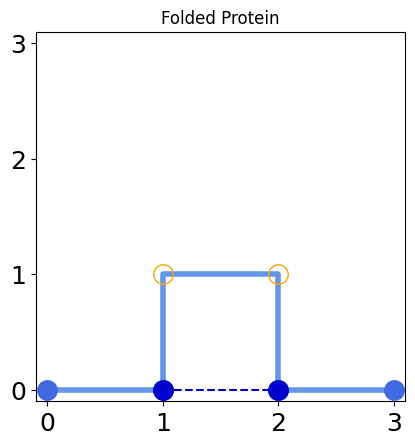

Episode 6, score: 0.0, epsilon: 1.00, reward_max: 1
	s_prime: [[0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]], reward: 0, done: True, info: {'chain_length': 6, 'seq_length': 6, 'actions': ['3', '2', '2', '4'], 'is_trapped': False, 'state_chain': OrderedDict([((0, 0), 'H'), ((1, 0), 'H'), ((1, -1), 'P'), ((2, -1), 'P'), ((3, -1), 'H'), ((3, 0), 'H')])}
Episode 7, score: 0.0, epsilon: 1.00, reward_max: 1
	s_prime: [[0 0 0 0 1]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 1 0 0 0]], reward: 0, done: True, info: {'chain_length': 6, 'seq_length': 6, 'actions': ['4', '4', '1', '1'], 'is_trapped': False, 'state_chain': OrderedDict([((0, 0), 'H'), ((1, 0), 'H'), ((1, 1), 'P'), ((1, 2), 'P'), ((0, 2), 'H'), ((-1, 2), 'H')])}
Episode 8, score: 0.0, epsilon: 1.00, reward_max: 1
	s_prime: [[0 0 0 1 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 1 0]], reward: 0, done: True, info: {'chain_length': 6, 'seq_length': 6, 'actions': ['3', '3', '1', '3'], 'is_trapped': False, 'state_chain': OrderedDict([((0, 0), 'H'), ((1, 

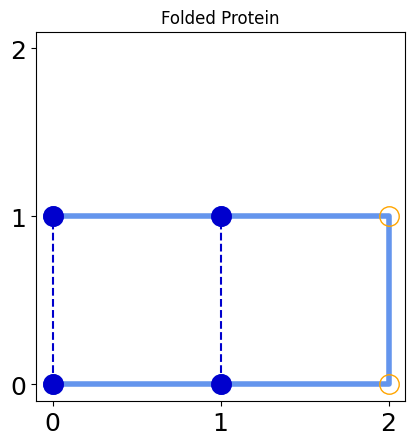

Streaming output truncated to the last 5000 lines.
 [0 1 0 0 0]], reward: 2, done: True, info: {'chain_length': 6, 'seq_length': 6, 'actions': ['2', '3', '1', '1'], 'is_trapped': False, 'state_chain': OrderedDict([((0, 0), 'H'), ((1, 0), 'H'), ((2, 0), 'P'), ((2, -1), 'P'), ((1, -1), 'H'), ((0, -1), 'H')])}
Episode 9001, score: 2.0, epsilon: 0.01, reward_max: 2
	s_prime: [[0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]], reward: 2, done: True, info: {'chain_length': 6, 'seq_length': 6, 'actions': ['2', '3', '1', '1'], 'is_trapped': False, 'state_chain': OrderedDict([((0, 0), 'H'), ((1, 0), 'H'), ((2, 0), 'P'), ((2, -1), 'P'), ((1, -1), 'H'), ((0, -1), 'H')])}
Episode 9002, score: 2.0, epsilon: 0.01, reward_max: 2
	s_prime: [[0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]], reward: 2, done: True, info: {'chain_length': 6, 'seq_length': 6, 'actions': ['2', '3', '1', '1'], 'is_trapped': False, 'state_chain': OrderedDict([((0, 0), 'H'), ((1, 0), 'H'), ((2, 0), 'P'), ((2, -1), 'P'), (

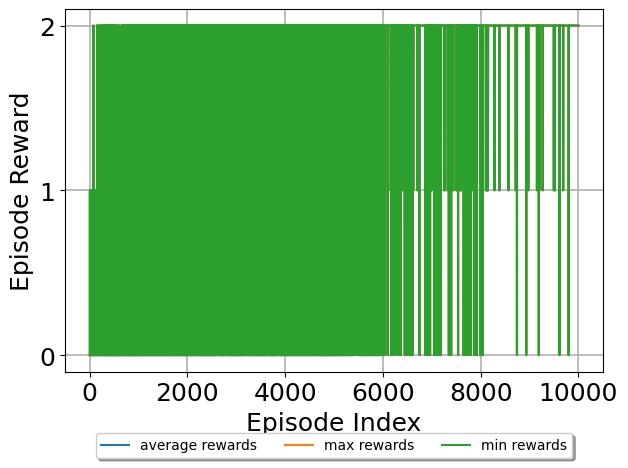

means =  1.3938


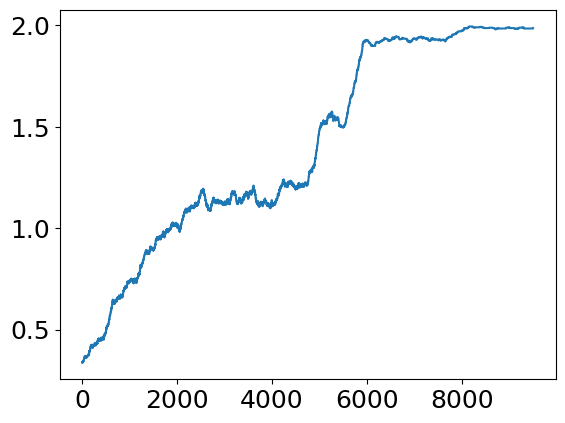

ValueError: ignored

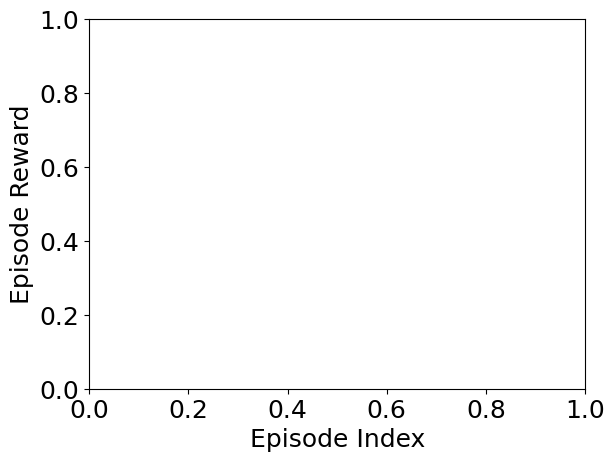

In [70]:
import argparse
# import csv
import gym
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sys



def one_hot_state(state_arr, action_depth):
    # print("after catting first_two_actions, state_arr = ", state_arr, state_arr.dtype, state_arr.shape)
    state_arr = F.one_hot(torch.from_numpy(state_arr), num_classes=action_depth)
    state_arr = state_arr.numpy()  # q.sample_action expects numpy arr
    return state_arr


seq = "HHPPHH" # Our input sequence
seed = 42  # read the seed from CMD
num_episodes = 10000  # number of episodes

max_steps_per_episode = len(seq) - 2

learning_rate = 0.0005
discount_rate = 0.9
# Exploration parameters
max_exploration_rate = 1
min_exploration_rate = 0

# render settings
show_every = num_episodes // 1000  # for plot_print_rewards_stats

rewards_all_episodes = np.zeros(
    (num_episodes,),
    # dtype=np.int32
)
reward_max = 0
num_trapped = 0

decay_mode = "exponential"  # exponential, cosine, linear
exploration_decay_rate = 5  # for exponential decay
start_decay = 0  # for exponential and linear

env = ProteinFoldingSquareEnv(seq)

torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)
initial_state = env.reset()


print("initial state/obs:")
print(initial_state)

# Get number of actions from gym action space
n_observations = len(seq)-2

col_length = env.observation_space.shape[0]

n_actions = env.action_space.n+1
hidden_size, num_layers, = 256, 2
print("n_actions = ", n_actions)
memory = ReplayBuffer(60000)
policy_net = FCN_QNet(col_length * n_actions,n_actions-1).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
target_net =FCN_QNet(col_length * n_actions,n_actions-1).to(device)
target_net.load_state_dict(policy_net.state_dict())
losses = []
eps = []
for n_episode in range(num_episodes):
    # = epsilon = max(min_exploration_rate, max_exploration_rate - exploration_decay_rate*(n_episode/200)) # linear annealing
    if decay_mode == "exponential":
        epsilon = ExponentialDecay(
            n_episode,
            num_episodes,
            min_exploration_rate,
            max_exploration_rate,
            exploration_decay_rate=exploration_decay_rate,
            start_decay=start_decay,
        )
    elif decay_mode == "linear":
        epsilon = LinearDecay(
            n_episode,
            num_episodes,
            min_exploration_rate,
            max_exploration_rate,
            start_decay=start_decay,
        )

    # reset the environment
    # Initialize the environment and state
    s = env.reset()
    
    s = one_hot_state(s,n_actions)
    done = False
    score = 0.0

    for step in range(max_steps_per_episode):

        a = policy_net.sample_action(torch.from_numpy(s).float().unsqueeze(0), epsilon)

        s_prime, r, done, truncated, info = env.step(a)

        while s_prime is None:
            # retry until action is not colliding
            # print("retry sample another action...")
            a = policy_net.sample_action(torch.from_numpy(s).float().unsqueeze(0), epsilon)
            # print("retried action = ", a)
            # Take the action (a) and observe the outcome state(s') and reward (r)
            s_prime, r, done, truncated, info = env.step(a)
        s_prime=one_hot_state(s_prime,n_actions)
        q_value = 0
        max_value = 0
        action = a
        done_mask = 0.0 if done else 1.0
        memory.put((s, a, r, s_prime, done_mask))
        if memory.size() >= BATCH_SIZE :
            eps.append(n_episode + 0.01*step)

        if done:
            if len(info['actions']) == (len(seq) - 2):
                pass
            else:
                num_trapped += 1
            break
        s = s_prime

    losses = train(policy_net, target_net, memory, optimizer, losses)

    # Update the target network, copying all weights and biases in DQN
    if n_episode % 100 == 0:
        target_net.load_state_dict(policy_net.state_dict())
    score = r
    rewards_all_episodes[n_episode] = score
    # update max reward found so far

    print("Episode {}, score: {:.1f}, epsilon: {:.2f}, reward_max: {}".format(
        n_episode,
        score,
        epsilon,
        reward_max,
    ))
    print(f"\ts_prime: {s_prime}, reward: {r}, done: {done}, info: {info}")
    if score > reward_max:
        print("found new highest reward = ", score)
        reward_max = score
        env.render()

print('Complete')

# ***** plot the stats and save in save_path *****

plot_print_rewards_stats(
    rewards_all_episodes,
    1,
    "args",
   "show",
    "fe"
)
plot_moving_avg(rewards_all_episodes, mode="show", save_path="v")

plot_loss(
    eps,
    losses
)
env.close()

print("\nnum_trapped = ", num_trapped)

# last line of the output is the max reward
print("\nreward_max = ", reward_max)

